# Racetrack Environment with Monte Carlo Control

This notebook implements the racetrack problem from Figure 5.5 in Sutton & Barto's RL textbook. We'll solve it using Monte Carlo control methods and analyze the impact of different crash penalty structures.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from tqdm import tqdm

# Import modules
from racetrack import RacetrackEnv, LargePenaltyEnv, CumulativeDamageEnv, FuelConsumptionEnv, PositionDependentPenaltyEnv
from monte_carlo import monte_carlo_control, generate_policy_trajectory, generate_random_trajectory, off_policy_monte_carlo
from visualization import visualize_track, visualize_policy, visualize_trajectory, plot_learning_curves

## 1. Environment Testing

First, create and visualize both tracks to ensuring they match Figure 5.5.

Successfully loaded custom left track
Successfully loaded custom right track


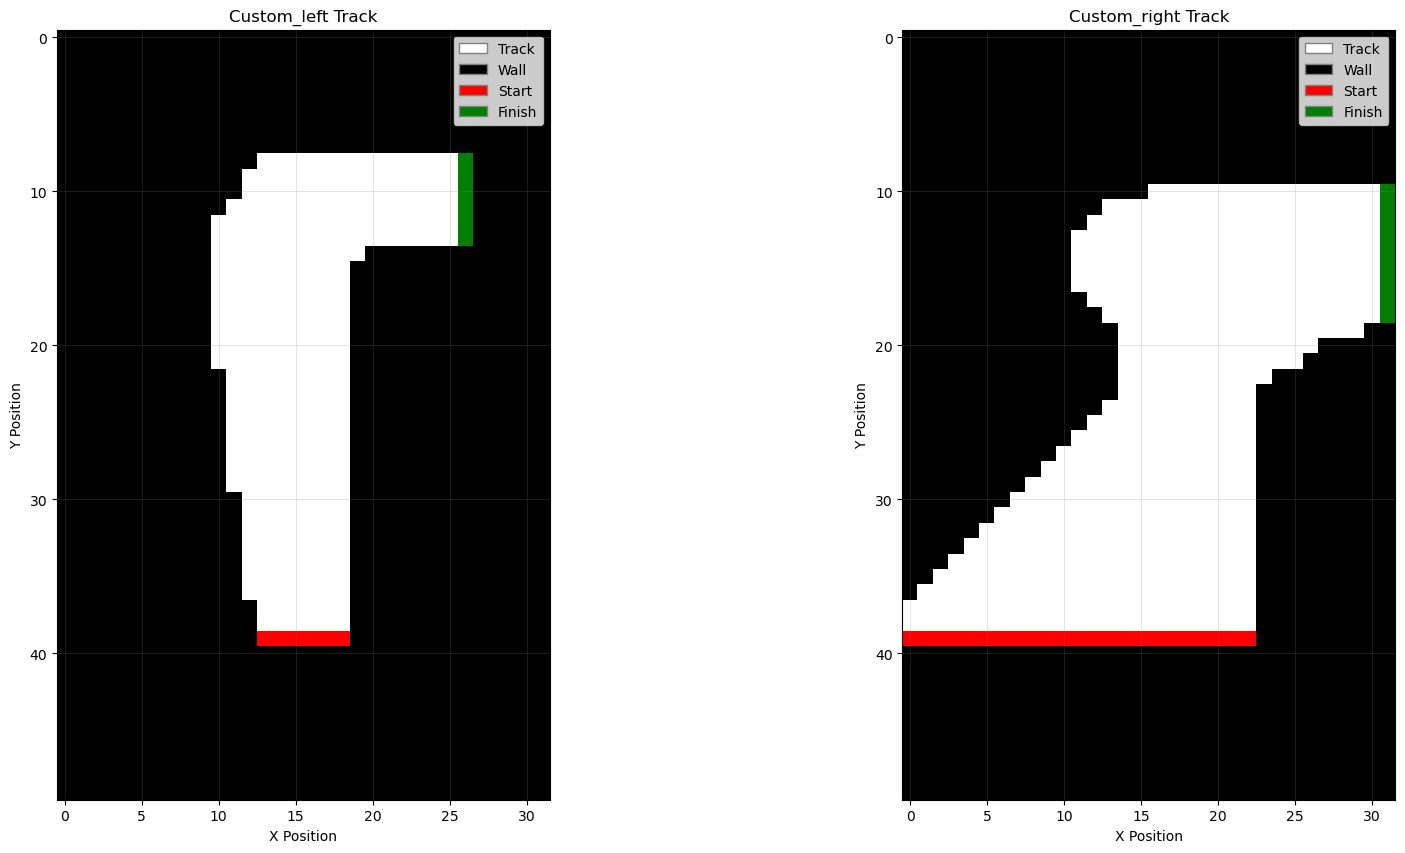

In [21]:
# Create both track environments
l_track = RacetrackEnv(track_type='custom_left')
diag_track = RacetrackEnv(track_type='custom_right')

# Visualize tracks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
visualize_track(l_track, ax1)
visualize_track(diag_track, ax2)
plt.show()

### Test Environment Dynamics

Let's test the environment dynamics by taking some random actions and visualizing the results.

Successfully loaded custom left track
Initial state: [np.int64(18), np.int64(39), 0, 0]
Step 1:
  Action: (0, 0)
  Next state: [x=18, y=39, vx=0, vy=0]
  Reward: -1, Done: False, Crash: True
Step 2:
  Action: (-1, 1)
  Next state: [x=17, y=38, vx=-1, vy=-1]
  Reward: -1, Done: False, Crash: False
Step 3:
  Action: (-1, -1)
  Next state: [x=15, y=38, vx=-2, vy=0]
  Reward: -1, Done: False, Crash: False
Step 4:
  Action: (1, -1)
  Next state: [x=14, y=39, vx=-1, vy=1]
  Reward: -1, Done: False, Crash: False
Step 5:
  Action: (0, -1)
  Next state: [x=17, y=39, vx=0, vy=0]
  Reward: -1, Done: False, Crash: True
Step 6:
  Action: (0, -1)
  Next state: [x=14, y=39, vx=0, vy=0]
  Reward: -1, Done: False, Crash: True
Step 7:
  Action: (0, -1)
  Next state: [x=15, y=39, vx=0, vy=0]
  Reward: -1, Done: False, Crash: True
Step 8:
  Action: (0, 0)
  Next state: [x=16, y=39, vx=1, vy=0]
  Reward: -1, Done: False, Crash: False
Step 9:
  Action: (1, 0)
  Next state: [x=18, y=39, vx=2, vy=0]
  Reward:

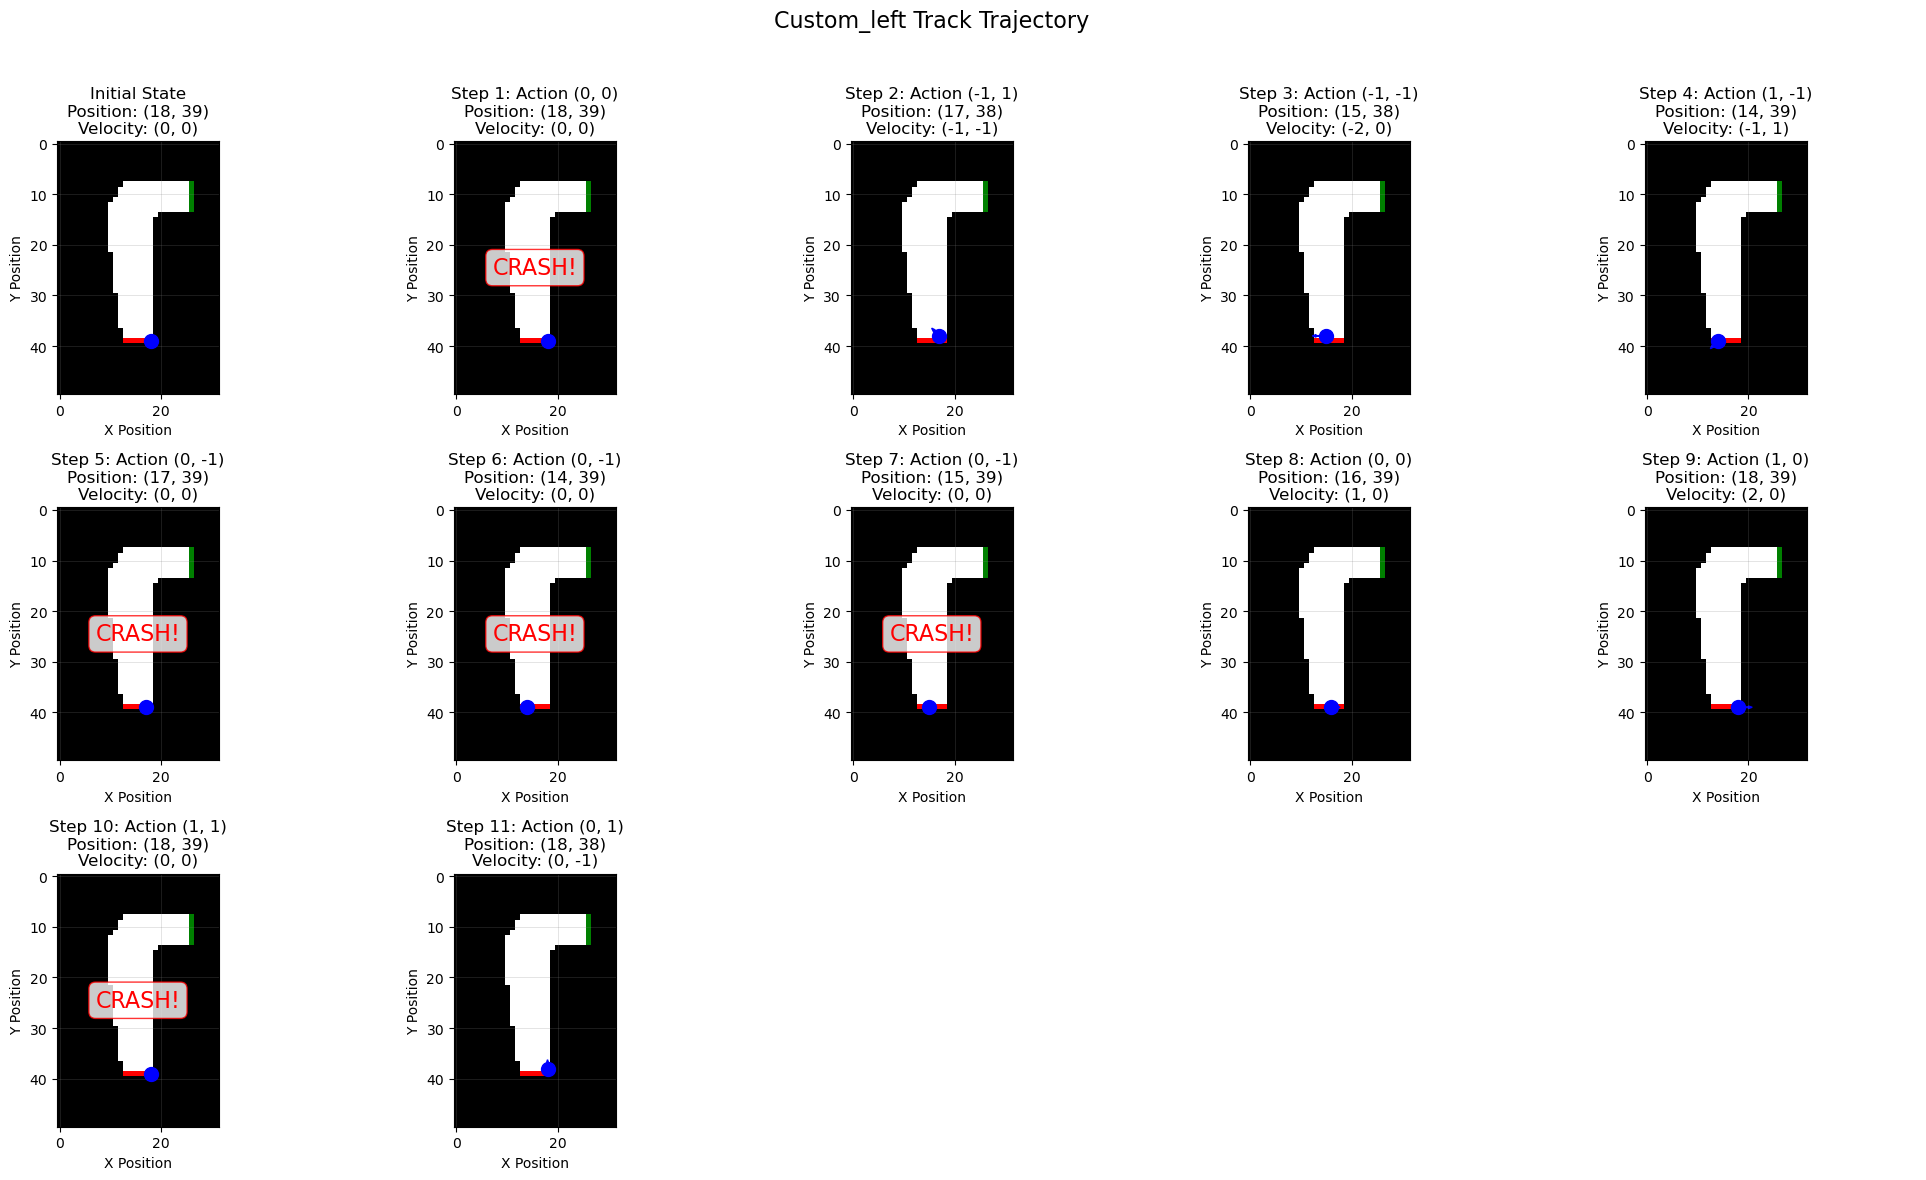

In [ ]:
def visualize_trajectory(env_type='custom_left', num_steps=10):
    """
    Run the environment for several steps and display all states in a single figure with subplots.
    """
    env = RacetrackEnv(env_type)
    state = env.reset()
    print(f"Initial state: {state}")
    
    # Create figure and subplots
    # Calculate an appropriate grid size based on num_steps
    cols = min(5, num_steps)  # Max 5 columns
    rows = (num_steps + cols - 1) // cols  # Ceiling division to ensure enough rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    # Convert axes to a 1D array for easy indexing
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()
    
    # Initial state (step 0)
    env.render(ax=axes[0])
    axes[0].set_title(f"Initial State\nPosition: ({state[0]}, {state[1]})\nVelocity: (0, 0)")
    
    # Take steps and update subplots
    states = [state]
    actions = []
    crashes = []
    rewards = []
    dones = []
    
    for i in range(num_steps - 1):  # -1 because we already plotted the initial state
        # Take a random action
        action = (np.random.randint(-1, 2), np.random.randint(-1, 2))
        next_state, reward, done, info = env.step(action)
        
        # Store information
        states.append(next_state)
        actions.append(action)
        crashes.append(info['crash'])
        rewards.append(reward)
        dones.append(done)
        
        print(f"Step {i+1}:")
        print(f"  Action: {action}")
        print(f"  Next state: [x={next_state[0]}, y={next_state[1]}, vx={next_state[2]}, vy={next_state[3]}]")
        print(f"  Reward: {reward}, Done: {done}, Crash: {info['crash']}")
        
        # Render this step in the next subplot
        env.render(ax=axes[i+1])
        axes[i+1].set_title(f"Step {i+1}: Action {action}\nPosition: ({next_state[0]}, {next_state[1]})\nVelocity: ({next_state[2]}, {next_state[3]})")
        
        # Add crash indicator if applicable
        if info['crash']:
            axes[i+1].text(0.5, 0.5, "CRASH!", 
                          transform=axes[i+1].transAxes,
                          fontsize=16, color='red', 
                          ha='center', va='center',
                          bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        
        # Check if done
        if done:
            axes[i+1].text(0.5, 0.4, "FINISH!", 
                          transform=axes[i+1].transAxes,
                          fontsize=16, color='green', 
                          ha='center', va='center',
                          bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
            print("Episode finished!")
            break
    
    # Hide any unused subplots
    for j in range(len(states), len(axes)):
        axes[j].axis('off')
    
    # Add overall title and adjust layout
    fig.suptitle(f"{env_type.capitalize()} Track Trajectory", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()
    
    return states, actions, crashes, rewards, dones

# Run the visualization with 12 steps
states, actions, crashes, rewards, dones = visualize_trajectory('custom_left', num_steps=10)

## 2. Monte Carlo Control

Now let's implement Monte Carlo control to learn a policy for the racetrack problem.

In [ ]:
# Run Monte Carlo control on L-shaped track (with a small number of episodes for testing)
env = RacetrackEnv('l_shaped')
num_episodes = 100  # Small for testing, increase for better results

policy, Q, stats = monte_carlo_control(env, num_episodes=num_episodes, epsilon=0.1)

# Plot learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(stats['returns'])
plt.title('Returns per Episode')
plt.xlabel('Episode')
plt.ylabel('Return')

plt.subplot(1, 3, 2)
plt.plot(stats['lengths'])
plt.title('Episode Length')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.subplot(1, 3, 3)
plt.plot(stats['crashes'])
plt.title('Crashes per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Crashes')

plt.tight_layout()
plt.show()

## 3. Policy Visualization

Let's visualize the learned policy and generate a trajectory using it.

In [ ]:
# Visualize policy
plt.figure(figsize=(10, 10))
visualize_policy(env, policy)
plt.title("Learned Policy (L-shaped Track)")
plt.show()

In [ ]:
# Generate and visualize a trajectory using the learned policy
policy_trajectory = generate_policy_trajectory(env, policy)
plt.figure(figsize=(10, 10))
visualize_trajectory(env, policy_trajectory)
plt.title(f"Policy Trajectory (Steps: {len(policy_trajectory)})")
plt.show()

## 4. Diagonal Track

Let's repeat the same process for the diagonal track.

In [ ]:
# Run Monte Carlo control on diagonal track
env = RacetrackEnv('diagonal')
num_episodes = 100  # Small for testing, increase for better results

diag_policy, diag_Q, diag_stats = monte_carlo_control(env, num_episodes=num_episodes, epsilon=0.1)

# Plot learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(diag_stats['returns'])
plt.title('Returns per Episode')
plt.xlabel('Episode')
plt.ylabel('Return')

plt.subplot(1, 3, 2)
plt.plot(diag_stats['lengths'])
plt.title('Episode Length')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.subplot(1, 3, 3)
plt.plot(diag_stats['crashes'])
plt.title('Crashes per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Crashes')

plt.tight_layout()
plt.show()

# Visualize policy
plt.figure(figsize=(10, 10))
visualize_policy(env, diag_policy)
plt.title("Learned Policy (Diagonal Track)")
plt.show()

# Generate and visualize a trajectory using the learned policy
diag_policy_trajectory = generate_policy_trajectory(env, diag_policy)
plt.figure(figsize=(10, 10))
visualize_trajectory(env, diag_policy_trajectory)
plt.title(f"Policy Trajectory (Steps: {len(diag_policy_trajectory)})")
plt.show()

## 5. Crash Penalty Variations

Let's compare different crash penalty structures to see how they affect the learned policy.

In [ ]:
# Compare crash penalties on a smaller scale for testing
track_type = 'l_shaped'
num_episodes = 100  # Small for testing, increase for better results

environments = {
    'Baseline': RacetrackEnv(track_type),
    'Large Penalty': LargePenaltyEnv(track_type)
    # Add more environments for full testing
    # 'Cumulative Damage': CumulativeDamageEnv(track_type),
    # 'Fuel Consumption': FuelConsumptionEnv(track_type),
    # 'Position-Dependent': PositionDependentPenaltyEnv(track_type)
}

results = {}

for name, env in environments.items():
    print(f"Training with {name} penalty...")
    policy, Q, stats = monte_carlo_control(env, num_episodes=num_episodes)
    results[name] = {
        'policy': policy,
        'Q': Q,
        'stats': stats
    }
    
    # Generate a trajectory using the learned policy
    policy_trajectory = generate_policy_trajectory(env, policy)
    
    # Visualize policy and trajectory
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    visualize_policy(env, policy, ax=axes[0])
    axes[0].set_title(f"{name} Policy")
    
    visualize_trajectory(env, policy_trajectory, ax=axes[1])
    axes[1].set_title(f"{name} Trajectory (Steps: {len(policy_trajectory)})")
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot comparison
fig, axes = plot_learning_curves(results)
plt.suptitle(f"Comparison of Crash Penalties on {track_type.capitalize()} Track")
plt.tight_layout()
plt.show()

## 6. Extra Credit: Off-policy Monte Carlo

Finally, let's compare on-policy and off-policy Monte Carlo methods.

In [ ]:
# Compare on-policy vs off-policy Monte Carlo
track_type = 'l_shaped'
num_episodes = 100  # Small for testing, increase for better results

env = RacetrackEnv(track_type)

# Run on-policy Monte Carlo
print("Training with on-policy Monte Carlo...")
on_policy, on_q, on_stats = monte_carlo_control(env, num_episodes=num_episodes)

# Run off-policy Monte Carlo
print("Training with off-policy Monte Carlo...")
off_policy, off_q, off_stats = off_policy_monte_carlo(env, num_episodes=num_episodes)

# Compile results
results = {
    'On-Policy': {
        'policy': on_policy,
        'Q': on_q,
        'stats': on_stats
    },
    'Off-Policy': {
        'policy': off_policy,
        'Q': off_q,
        'stats': off_stats
    }
}

# Plot comparison
fig, axes = plot_learning_curves(results)
plt.suptitle(f"Comparison of On-Policy vs Off-Policy MC on {track_type.capitalize()} Track")
plt.tight_layout()
plt.show()

In [ ]:
# Compare trajectories
on_trajectory = generate_policy_trajectory(env, on_policy)
off_trajectory = generate_policy_trajectory(env, off_policy)

# Visualize policies and trajectories
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

visualize_policy(env, on_policy, ax=axes[0, 0])
axes[0, 0].set_title("On-Policy Monte Carlo Policy")

visualize_trajectory(env, on_trajectory, ax=axes[0, 1])
axes[0, 1].set_title(f"On-Policy Trajectory (Steps: {len(on_trajectory)})")

visualize_policy(env, off_policy, ax=axes[1, 0])
axes[1, 0].set_title("Off-Policy Monte Carlo Policy")

visualize_trajectory(env, off_trajectory, ax=axes[1, 1])
axes[1, 1].set_title(f"Off-Policy Trajectory (Steps: {len(off_trajectory)})")

plt.tight_layout()
plt.show()

## 7. Full Experiment

For a full experiment with more training episodes and all penalty variations, you can run the functions from main.py:

In [ ]:
from main import experiment_basic, compare_crash_penalties, experiment_off_policy

# Uncomment and run these functions for a full experiment
# Note: These will take longer to run with more episodes

# Basic experiment on L-shaped track
# l_policy, l_q, l_stats = experiment_basic('l_shaped', num_episodes=1000)

# Basic experiment on diagonal track
# d_policy, d_q, d_stats = experiment_basic('diagonal', num_episodes=1000)

# Compare crash penalties on L-shaped track
# penalty_results = compare_crash_penalties('l_shaped', num_episodes=1000)

# Compare on-policy vs off-policy Monte Carlo
# off_policy_results = experiment_off_policy('l_shaped', num_episodes=1000)